# Microchip Study and Analysis
#### Mauricio Martinez, Jaime Guerra, Brenda Cervantes, Pedro Silves
Terminado al 03 oct 2023

In [33]:
from functions_py import *
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import chisquare as chisquare
import pickle

#ICN
sys.path.insert(0, '/home/oem/Software/Serial_Register_Events_Detection')
#LapTop Mau
#sys.path.insert(0, '/home/mauricio/Software/Serial_Register_Events_Detection')

In [34]:
from ReconLib import *

#### Functions

In [35]:
# Funtions
def hist_RowColumn(data_array):
    Col=np.median(data_array, axis=0)
    #Col=data[10:640,0]#analisis de Registro vertical, Columnas V
    bins_Col=np.histogram_bin_edges(Col, bins='fd')
    Col_hist, bins_Col = np.histogram(Col,bins=bins_Col)
    u_Col, std_Col = norm.fit(Col)
    

    Row=np.median(data_array, axis=1)
    #Row=data[10,10:690] #analisis de Registro horizontal, Renglones H    
    bins_Row=np.histogram_bin_edges(Row, bins='fd')
    Row_hist, bins_Row = np.histogram(Row,bins=bins_Row) 
    u_Row, std_Row = norm.fit(Row)
    

    print('media on Row='+str(u_Row)+', stdDev on y='+str(std_Row))
    print('media on Col='+str(u_Col)+', stdDev on y='+str(std_Col))

    return Row, Col, bins_Row, bins_Col, Row_hist, Col_hist #Row_median, Col_median, bines Row, bines Col, Histogram Row, histogram Col

def line(x, m, b): #data, slope, y-intersection (ordenada al origen)
    return (m*x+b)

def secOrder(x,a,b,c):
    return a*x**2 + b*x + c 

def totTime(path):
    hdul=fits.open(path)# fits file to analyze
    header=hdul[0].header

    tStartList=str(header._cards[159]).split("'")[1].split('T')[1].split(':')
    tEndList=str(header._cards[160]).split("'")[1].split('T')[1].split(':')

    tStart=int(tStartList[0])*3600+int(tStartList[1])*60+int(tStartList[2])
    tEnd=int(tEndList[0])*3600+int(tEndList[1])*60+int(tEndList[2])

    dateStart=header._cards[159][1].split('T')[0]
    dateEnd=header._cards[160][1].split('T')[0]
    if (int(dateEnd.split('-')[-1])-int(dateStart.split('-')[-1])) >0:
        Ttot=tEnd+86400-tStart        # Total time 
    else:
        Ttot=tEnd-tStart        # Total time 

    NRow=int(str(header._cards[15]).split("'")[1])
    NCol=int(str(header._cards[16]).split("'")[1])
    NSamp=int(str(header._cards[17]).split("'")[1])


    deltaTperPix=Ttot/(NCol*NRow)
    deltaTperRow=Ttot/NRow

    expoTimes=[]
    
    for mCol in range(0,NCol):  #Fill Exposure Matrix
        expoTimes.append([])
        for nRow in range(0,NRow):
            expoTimes[mCol].append(deltaTperRow*mCol+deltaTperPix*nRow)


    ExpoMatrix=np.array(expoTimes)
    #NROW650_NCOL700
        
    
    return ExpoMatrix, Ttot, NRow, NCol, NSamp

def exposureFactor(path):
    ExpoMatrix,_,_,_,_=totTime(path)
    fig_all, axs_all = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),constrained_layout=True)		# Create figures
    fig_all.suptitle('Exposure Factor', fontsize='large')
    popt, pcov = curve_fit(line, range(0, len(ExpoMatrix[0])),ExpoMatrix[0]) #ajustar valores de x y yRuido a la funcion "func"
    axs_all[0].set_title('Horizontal')
    axs_all[0].set_ylim([-4, 15])
    axs_all[0].set_ylabel('Exposure time [s]')
    axs_all[0].set_xlabel('Col')
    axs_all[1].set_xlabel('Row')
    axs_all[0].plot(range(0,len(ExpoMatrix[0])), line(range(0,len(ExpoMatrix[0])), popt[0], popt[1]),'r-', label='fit: m=%f [s/pix], b=%f' % tuple(popt))
    HEF=popt[0] #Horizontal exposure factor
    axs_all[0].legend()
    popt, pcov = curve_fit(line, range(0, len(ExpoMatrix[:,0])),ExpoMatrix[:,0])
    axs_all[1].set_title('Vertical')
    axs_all[1].plot(range(0,len(ExpoMatrix[:,0])), line(range(0,len(ExpoMatrix[:,0])), popt[0], popt[1]),'b-', label='fit by column: m=%f [s/pix], b=%f' % tuple(popt))
    VEF=popt[0] #Vertical Exposure Factor
    axs_all[1].legend()
    plt.show()
    return HEF, VEF

def sum_intensity(region, intensities):
    return np.sum(intensities[region])






#### Format of images

In [36]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

# Microchip images

## Raw Image

Filename: /home/oem/datosFits/serialRegEvents/21NOV23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_68.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 400)   float32   
  1                1 ImageHDU       164   (700, 400)   float32   
  2                1 ImageHDU       164   (700, 400)   float32   
  3                1 ImageHDU       164   (700, 400)   float32   
None
----------------


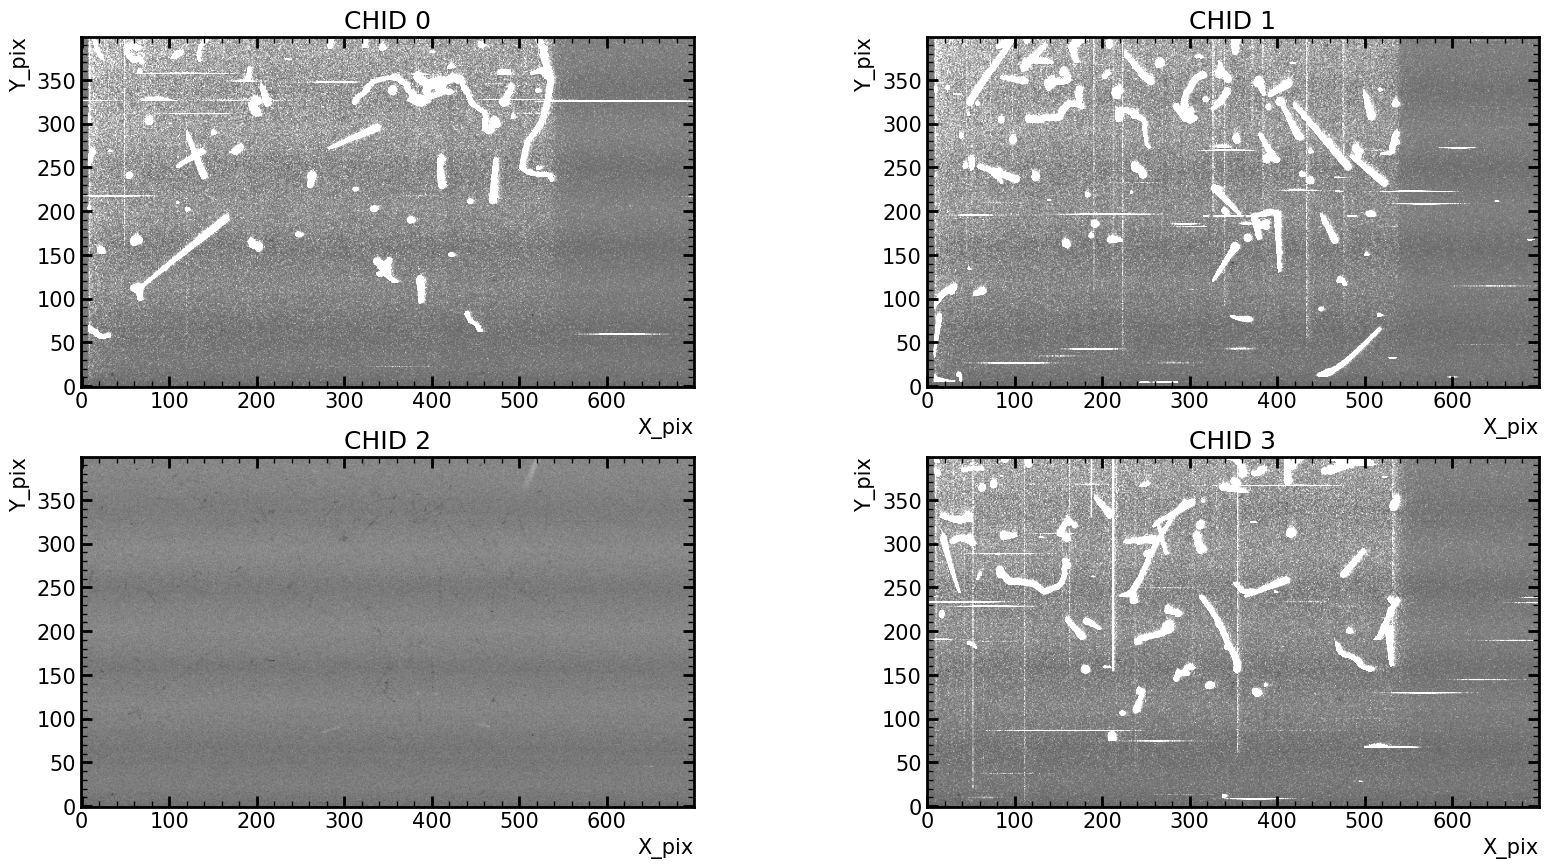

In [37]:
# ICN
# path='/home/oem/datosFits/spuriousCharge/Microchip/14AUG23/proc_skp_module24_MITLL01_externalVr-4_Vv2_T140__NSAMP324_NROW250_NCOL700_EXPOSURE0_NBINROW1_NBINCOL1_img105.fits'
path = '/home/oem/datosFits/serialRegEvents/21NOV23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_68.fits'
# LapTop Mau
# path='/home/mauricio/datosFits/spuriousCharge/Microchip/14AUG23/proc_skp_module24_MITLL01_externalVr-4_Vv2_T140__NSAMP225_NROW650_NCOL700_EXPOSURE0_NBINROW1_NBINCOL1_img109.fits'
#path='/home/oem/datosFits/serialRegEvents/13OCT23/All/nsamp_324/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_103.fits'

hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=-800,vmax=800,cmap='gray')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

### Distribucion de pixeles de la ext[0]

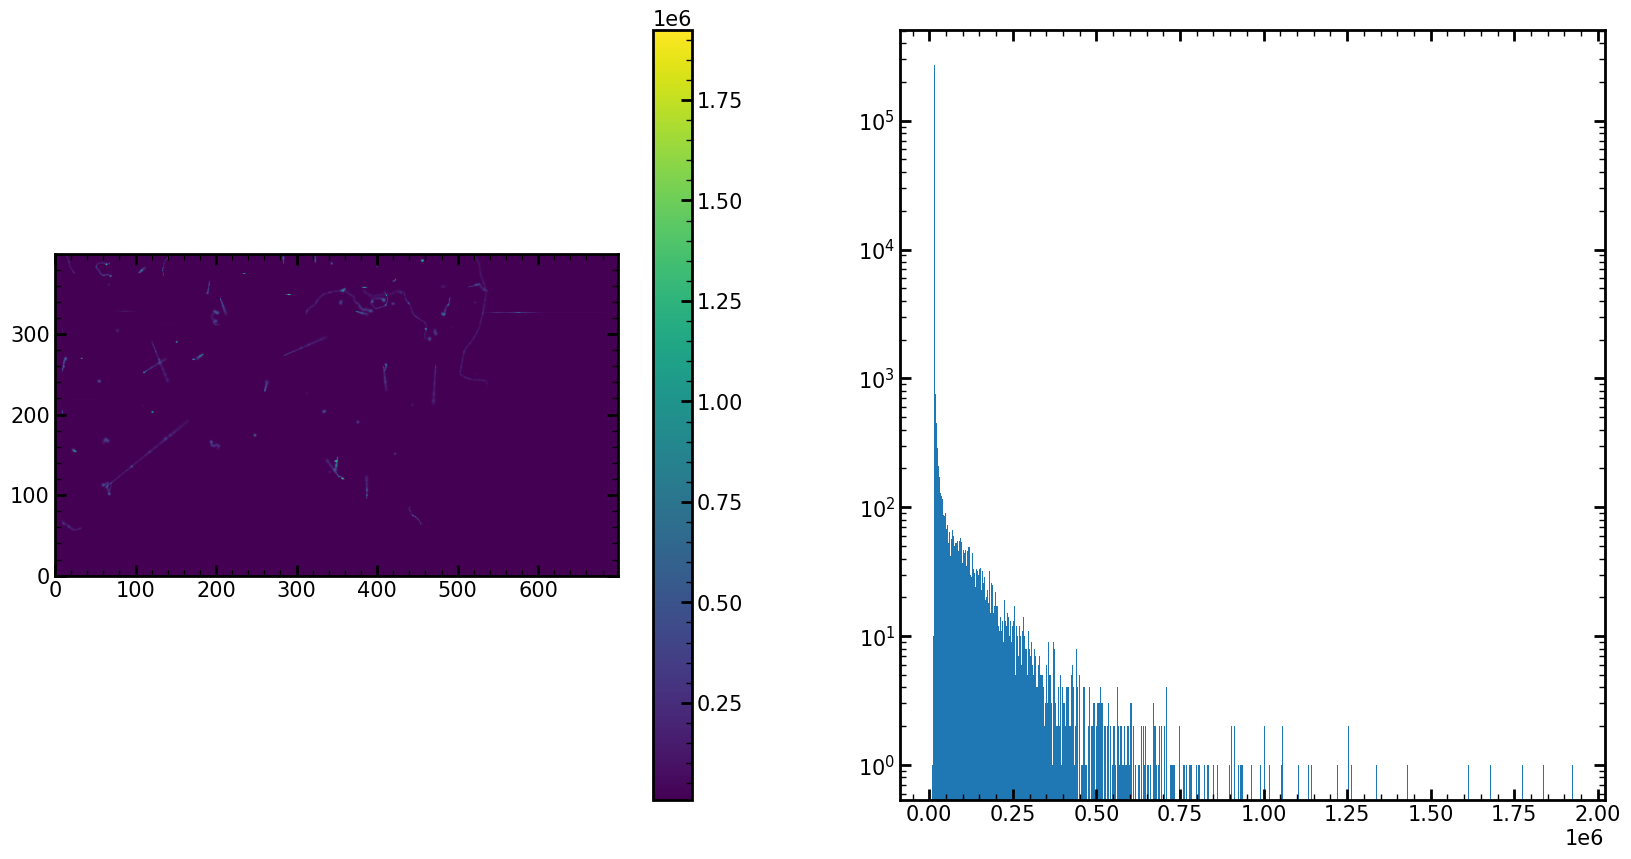

In [38]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(hdu_list[0].data)
plt.colorbar()

plt.subplot(1,2,2)
histogram=plt.hist(hdu_list[0].data.flatten(), bins=1000, log=True)

### Antes de Calibrar: Identificar los eventos que se encuentran en la imagen
* rayos cosmicos, electrones, etc
* Eventos de registro serial

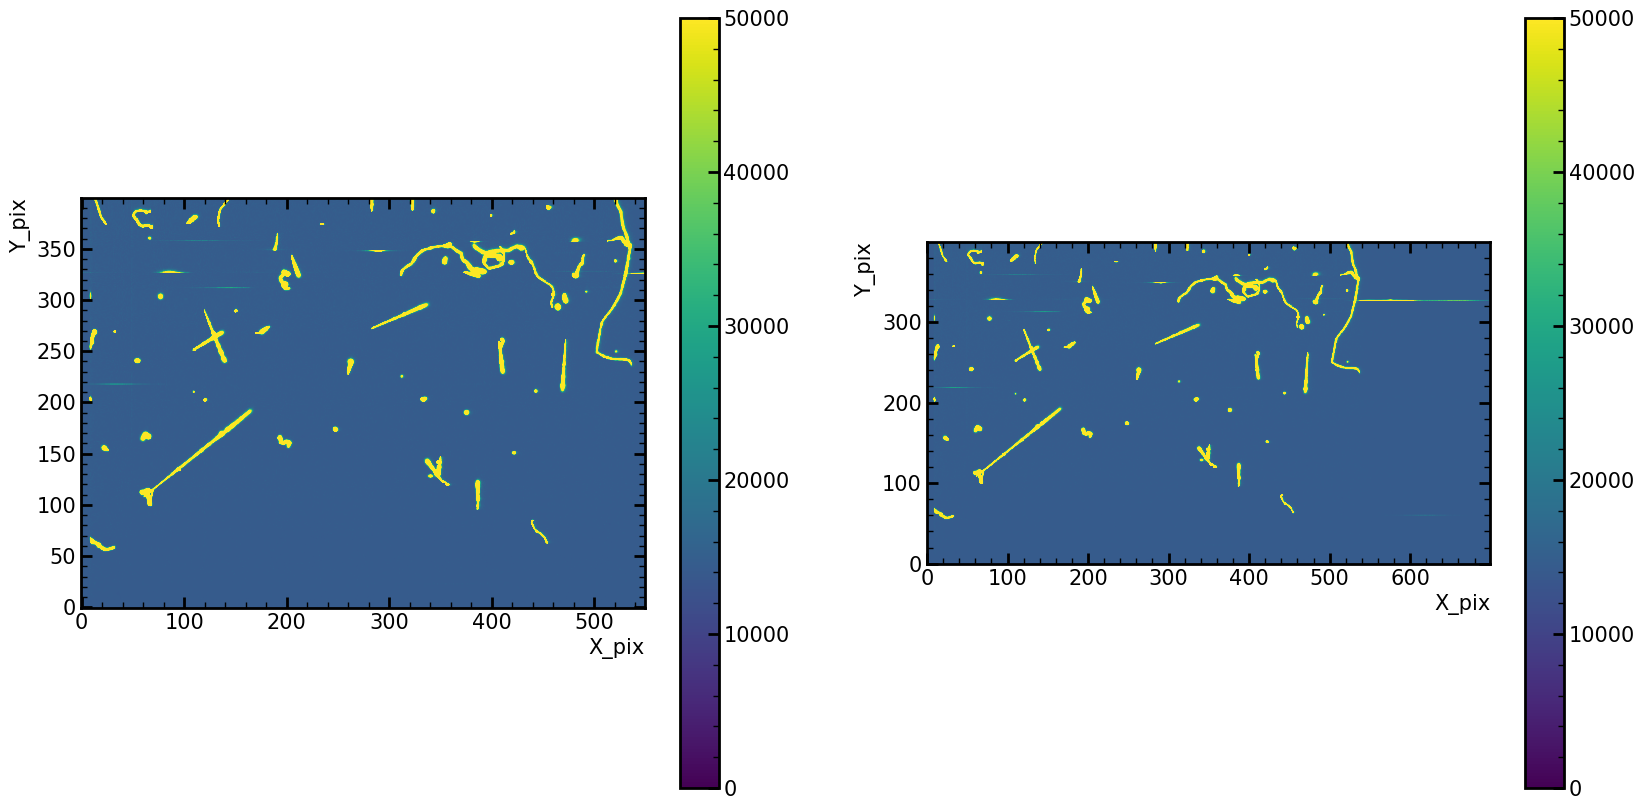

In [39]:
Plot2Images(hdu_list[0].data[:,:550], hdu_list[0].data, MaxRange=50000,MinRange=0) #data and data with max and min defined
#PlotImage(hdu_list[0].data)

In [40]:
serialRegisterEvents_n25, _, _, _   =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 2.5,extend=True,overscan=550,frames=15)
serialRegisterEvents_n3, _, _, _    =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 3,extend=True,overscan=550,frames=15)
serialRegisterEvents_n35, _, _, _   =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 3.5,extend=True,overscan=550,frames=15)
serialRegisterEvents_n4, _, _, _    =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 4,extend=True,overscan=550,frames=15)
serialRegisterEvents_n5, CCDMask, _, _=makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 5,extend=True,overscan=550,frames=15)

In [41]:
serialRegisterEvents_n55, _, _, _   =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 5.5, extend=True,overscan=550,frames=15)
serialRegisterEvents_n6, _, _, _    =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 6, extend=True,overscan=550,frames=15)
serialRegisterEvents_n65, _, _, _   =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 6.5, extend=True,overscan=550,frames=15)
serialRegisterEvents_n7, _, _, _    =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 7, extend=True,overscan=550,frames=15)
serialRegisterEvents_n75, CCDMask, _, _=makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 7.5, extend=True,overscan=550,frames=15)

In [42]:
serialRegisterEvents_n3, _, _, _    =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 3,extend=True,overscan=550,frames=15)

### Analysis on OS

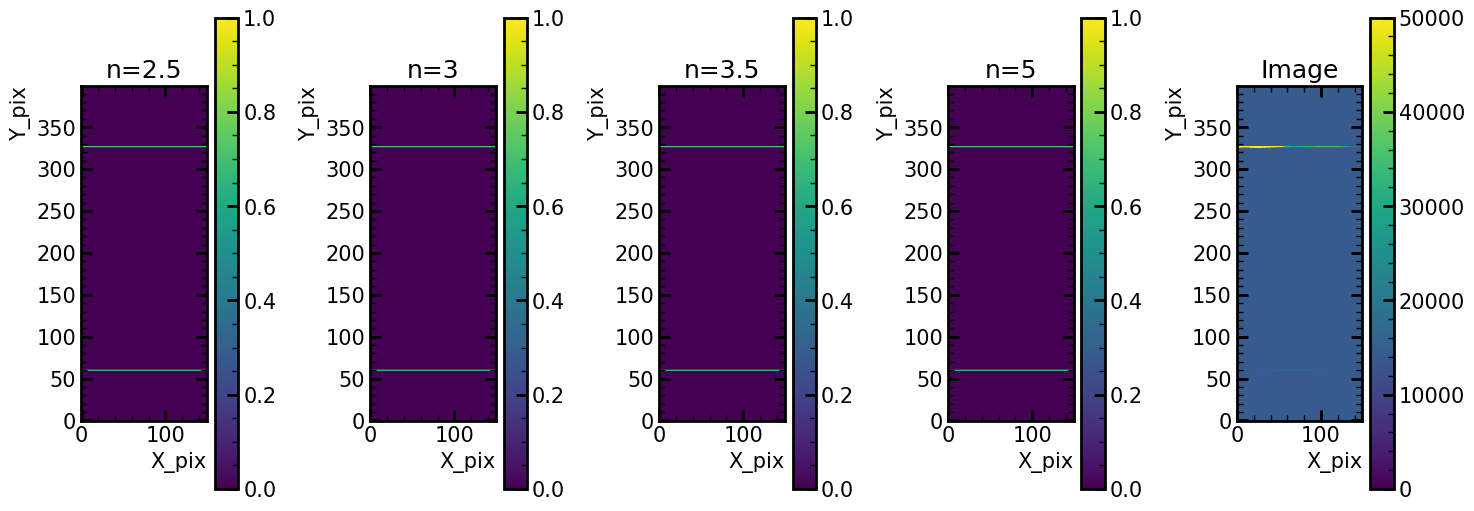

In [43]:
OS_comparison(serialRegisterEvents_n25,serialRegisterEvents_n3,serialRegisterEvents_n35,serialRegisterEvents_n5,hdu_list[0].data,colorBar_1=True, MaxRange=50000, titleImage=['2.5','3','3.5','5'])

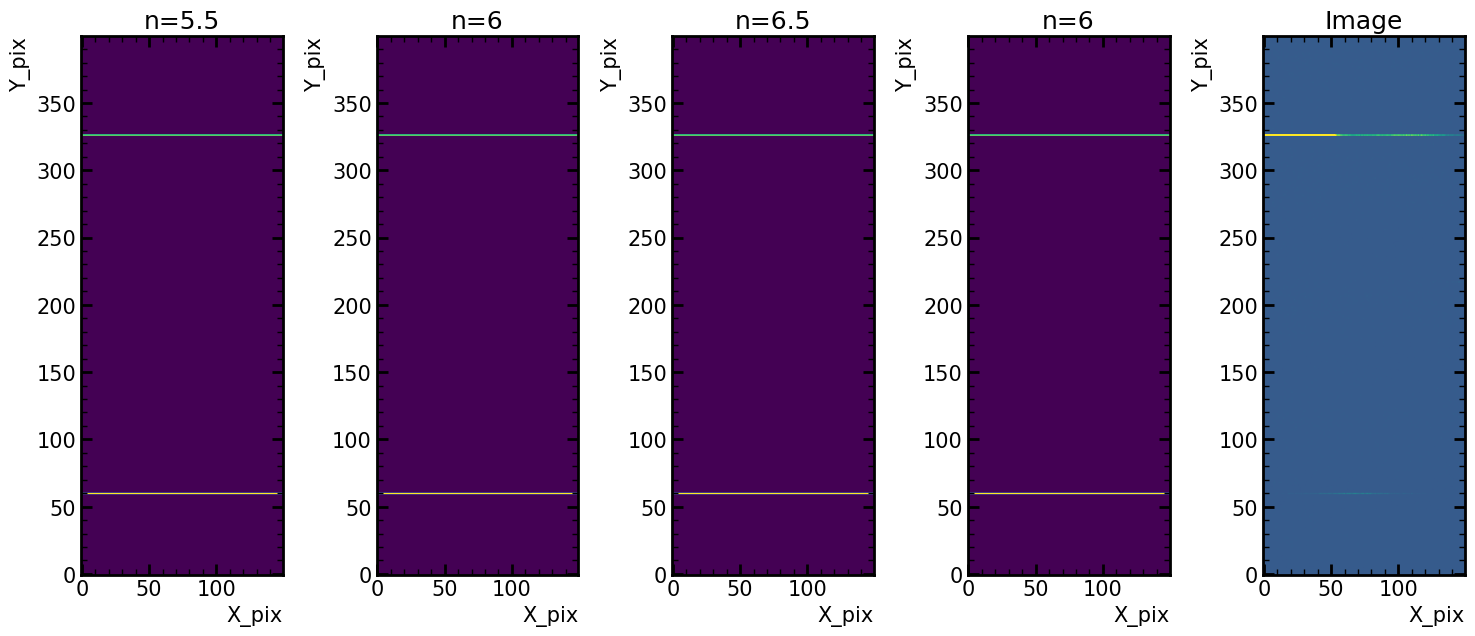

In [44]:
#OS_comparison(serialRegisterEvents_n25[:,550:],serialRegisterEvents_n3[:,550:],serialRegisterEvents_n35[:,550:],serialRegisterEvents_n4[:,550:],hdu_list[0].data[:,550:] ,colorBar_1=False, MaxRange=100, titleImage=[1,2,3,4])
OS_comparison(serialRegisterEvents_n5,serialRegisterEvents_n55,serialRegisterEvents_n6,serialRegisterEvents_n65,hdu_list[0].data,colorBar_1=False, MaxRange=50000, titleImage=['5.5','6','6.5','6'])

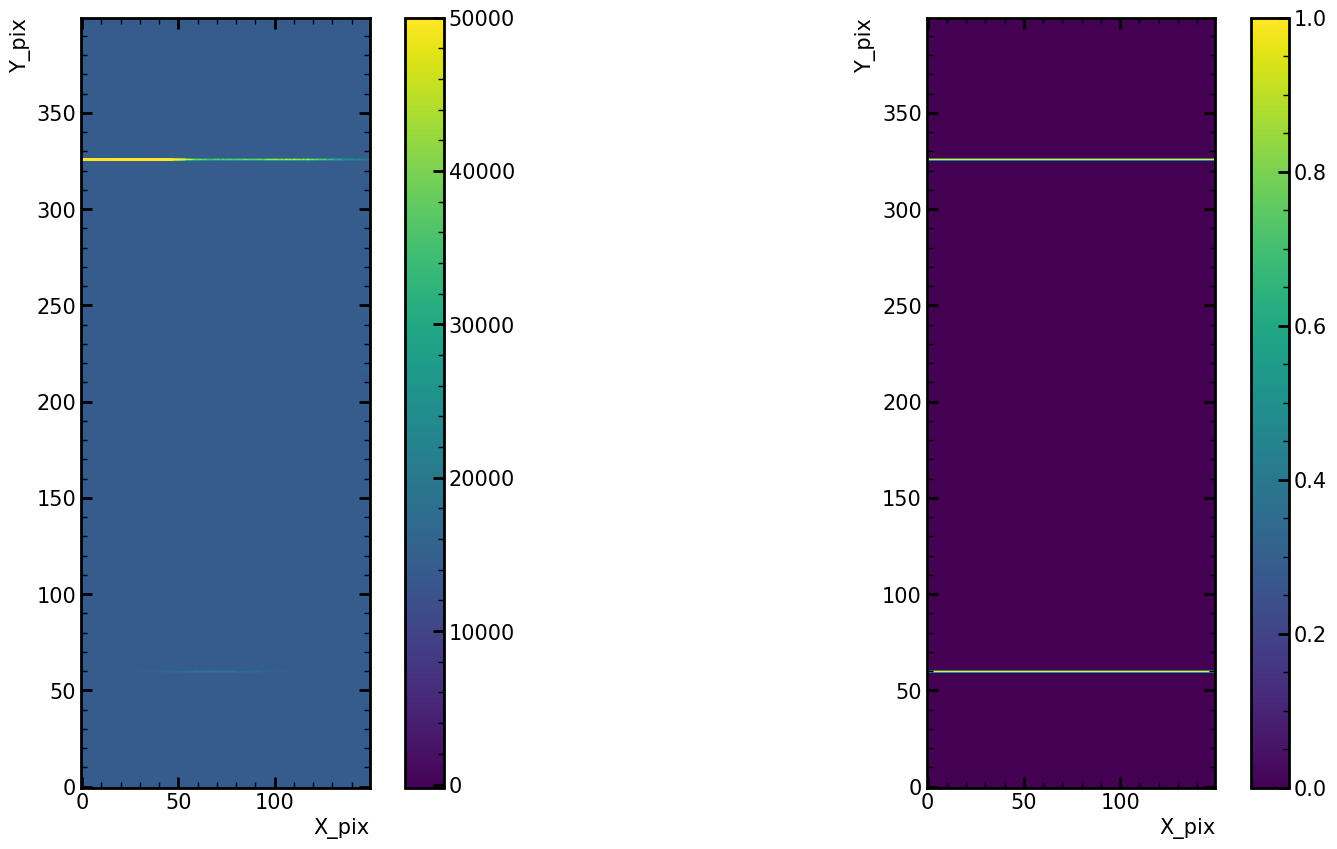

In [45]:
Plot2Images(hdu_list[0].data[:,550:],serialRegisterEvents_n5[:,550:],MaxRange=50000,MinRange=-200)

In [46]:
serialRegisterEvents_n25.max()

1.0

### Utilizando un Valor de Std Dev definido unicamente para el OS generamos una mascara que permita detectar Eventos de Registro Serial

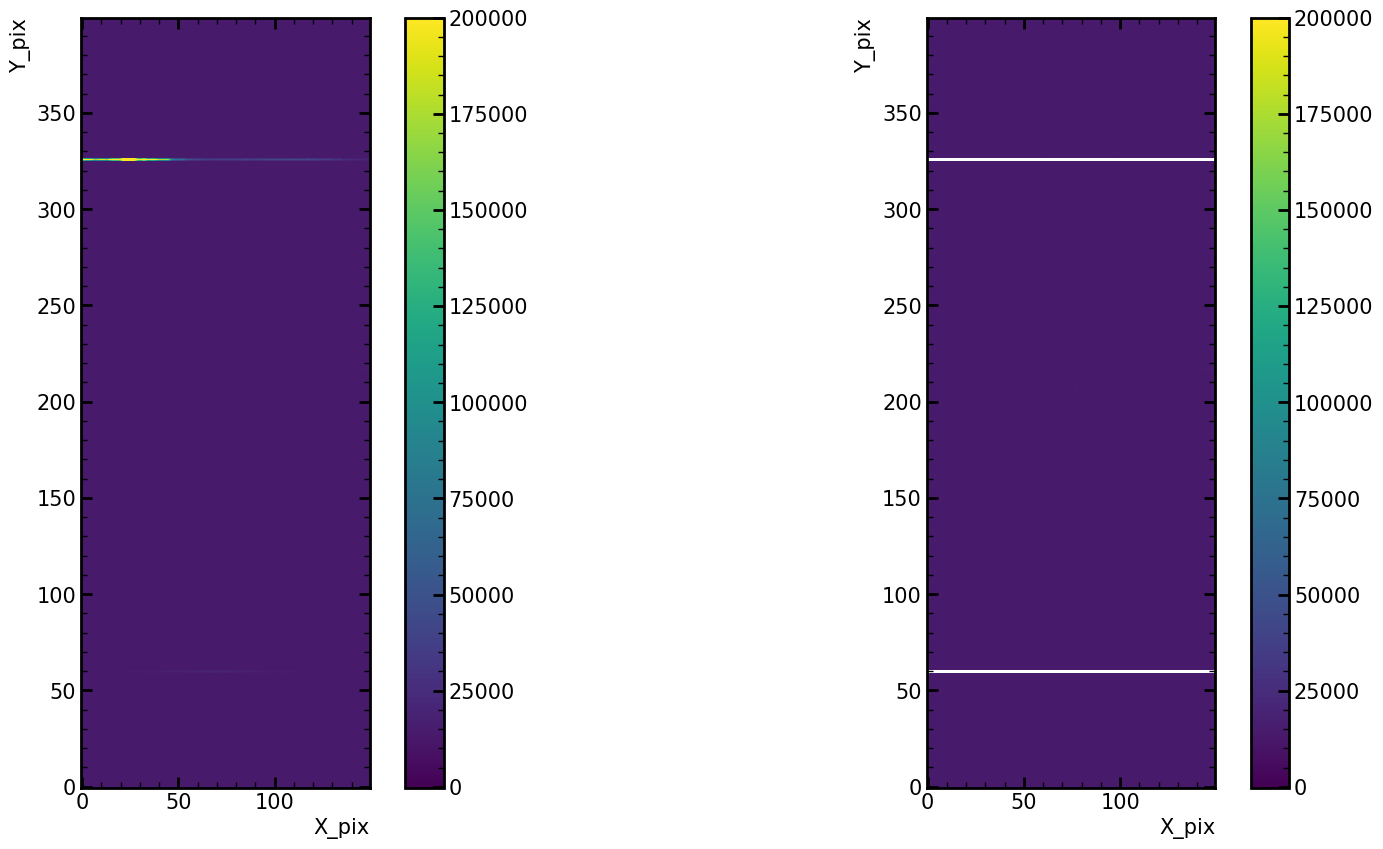

In [47]:
la_mascara=ma.masked_array(hdu_list[0].data, mask=serialRegisterEvents_n5)
Plot2Images(hdu_list[0].data[:,550:], la_mascara[:,550:],MinRange=-200, MaxRange=200000)

### Podemos observar como en el histograma no enmascarado existen pixeles en el orden de 1E6 [ADU]
### Enmascarando los eventos de Registro Serial e indicando que el rango del histograma este entre el valor minimo y maximo de los datos utilizados nos damos cuenta de que la figura concentra solo datos entre 0 y 1500 [ADU]

Offset Value:  14371.094  ADUs


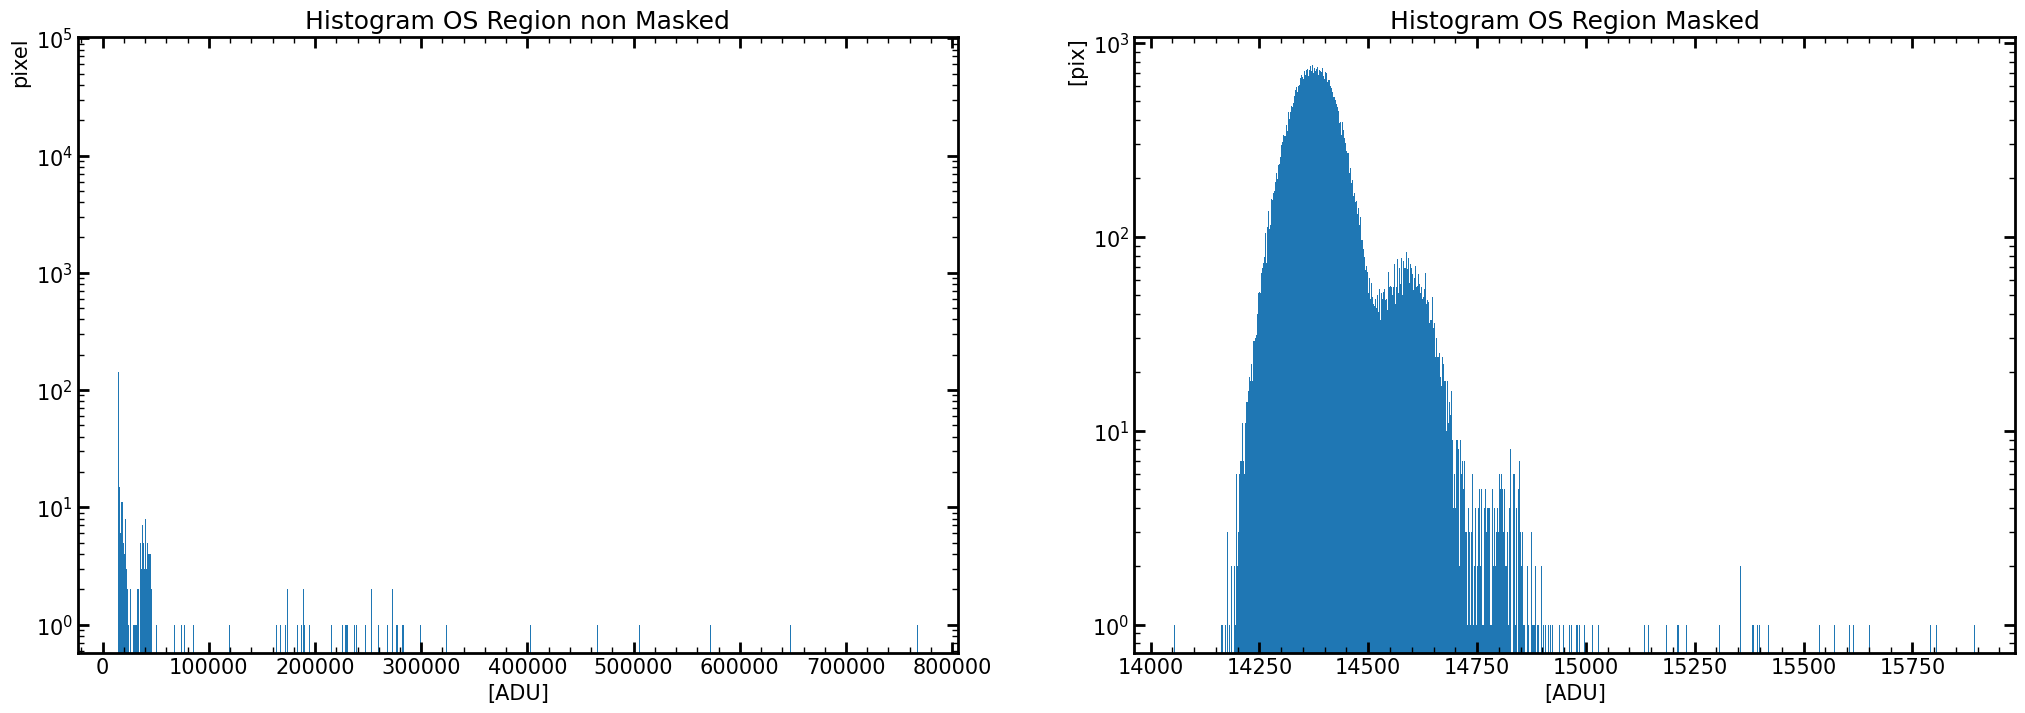

In [48]:
fig=plt.figure(figsize=(25,8))

plt.subplot(1,2,2)
plt.title('Histogram OS Region Masked')
plt.ylabel('[pix]')
plt.xlabel('[ADU]', loc='center')
histograma_OS, bines_OS, _ = plt.hist(la_mascara[:,550:].flatten(), bins=1000, range=(la_mascara[:,550:].min(),la_mascara[:,550:].max()), log=True)

plt.subplot(1,2,1)
plt.title('Histogram OS Region non Masked')
plt.ylabel('pixel')
plt.xlabel('[ADU]', loc='center')
histograma, bines, _= plt.hist(hdu_list[0].data[:,550:].flatten(), bins=1000, range=(hdu_list[0].data[:,550:].min(),hdu_list[0].data[:,550:].max()), log=True) 

offset = bines_OS[np.argmax(histograma_OS)]
print('Offset Value: ', offset, ' ADUs')




### Analysis on Active Region
Mask of Serial Register Events

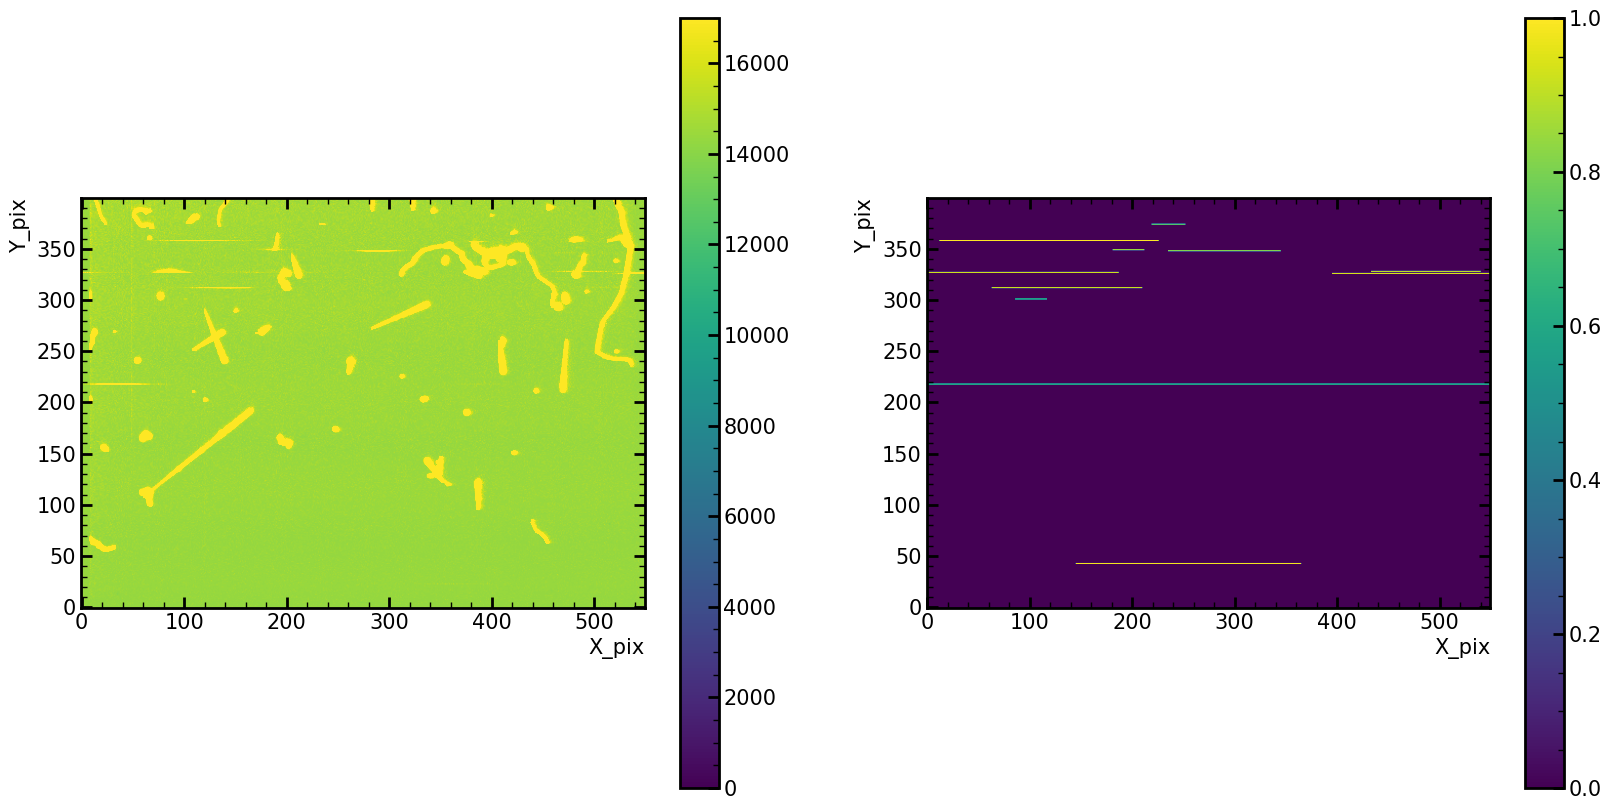

In [49]:
Plot2Images(hdu_list[0].data[:,:550], serialRegisterEvents_n3[:,:550],MinRange=0, MaxRange=17000)

# Combinamos Mascara de eventos con eventos de Reg Serial
### Definimos un humbral superior en ADUs para resaltar los eventos sobre el fondo y combinamos esa mascara con la anterior

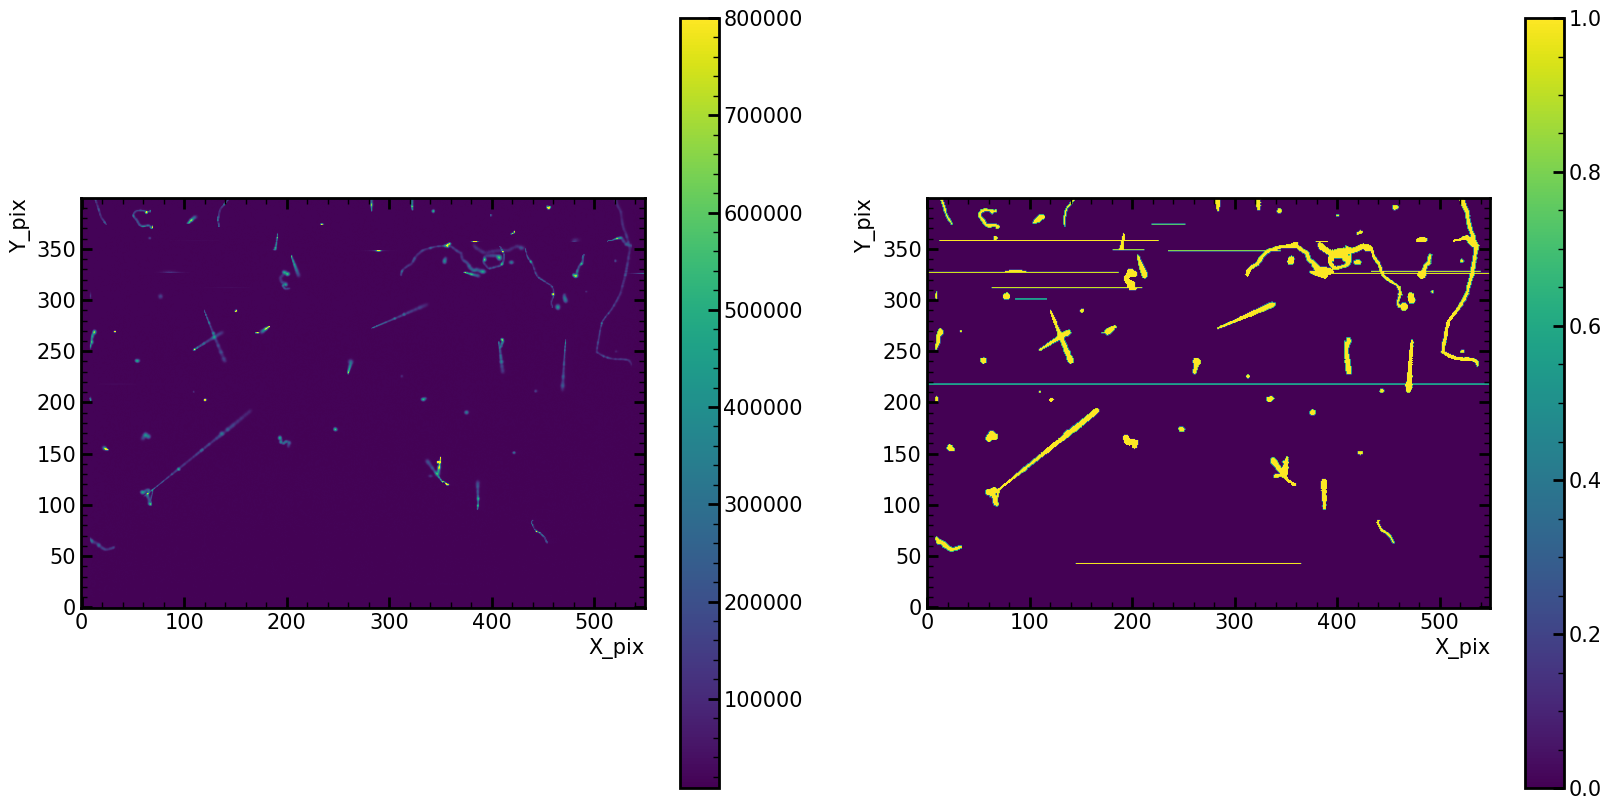

In [50]:
label=ndimage.label(hdu_list[0].data[:,:550]>20000,structure=[[1,1,1],[1,1,1],[1,1,1]])[0]

#Event Mask
event_mask=np.invert(label==0)

#Serial Register Event mask
serial_mask=np.ma.make_mask(serialRegisterEvents_n3[:,:550])

#Combined Masks
main_mask=np.ma.mask_or(event_mask, serial_mask)

Plot2Images(hdu_list[0].data[:,:550], main_mask, MinRange=hdu_list[0].data[:,:550].min(), MaxRange=800000)


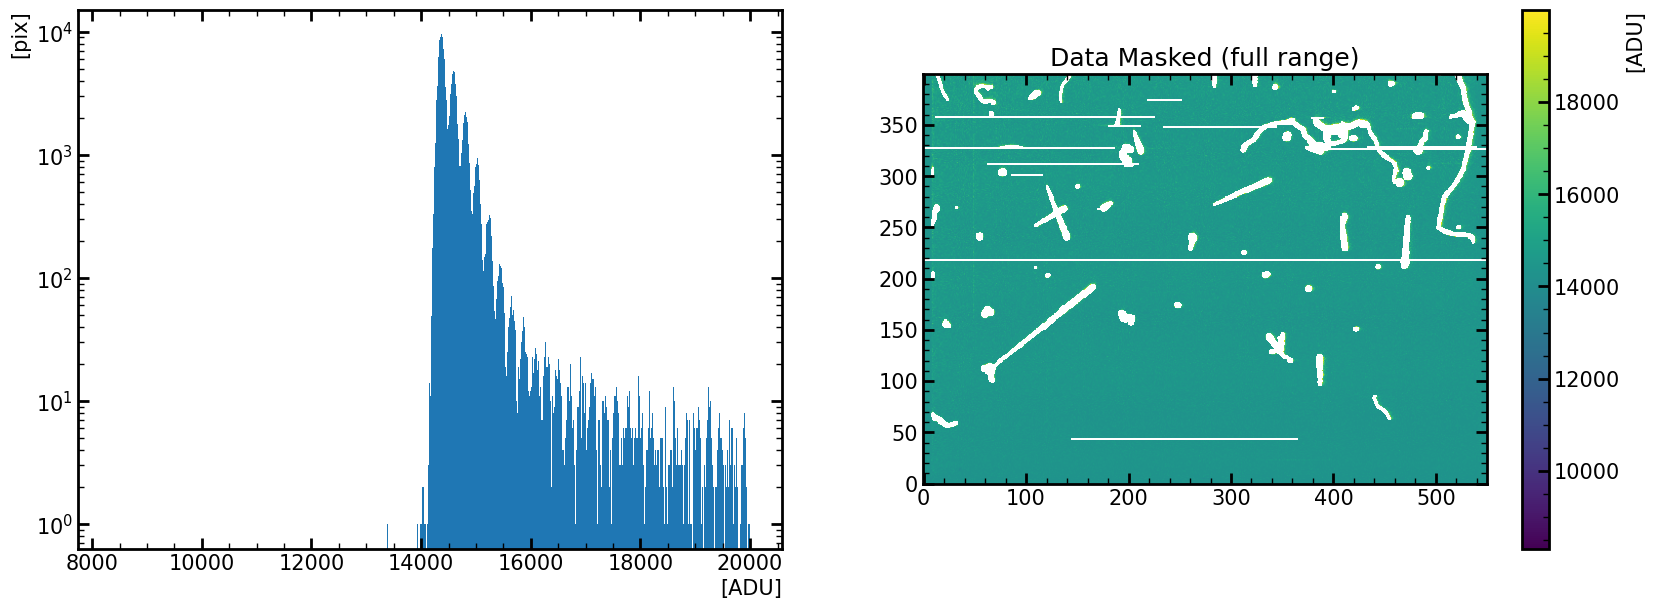

In [51]:
background_data=np.ma.masked_array(hdu_list[0].data[:,:550], mask=main_mask)

fig=plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
histograma_AA=plt.hist(background_data.flatten(), bins=1000, log=True, range=(background_data.flatten().min(),background_data.flatten().max()))
plt.xlabel('[ADU]')
plt.ylabel('[pix]')

plt.subplot(1,2,2)
plt.title('Data Masked (full range)')
plt.imshow(background_data, vmin=background_data.flatten().min(),vmax=background_data.flatten().max())
cbar=plt.colorbar()
cbar.set_label('[ADU]')




## Enmascarar eventos por debajo de -200 ADU
### No se realmente cual es la naturaleza de los pixeles que contienen valores negativos (MUY negativos)

In [52]:
neg_label=ndimage.label(hdu_list[0].data[:,:550] < 14000,structure=[[1,1,1],[1,1,1],[1,1,1]])[0]
neg_mask=np.invert(neg_label==0)
final_mask=np.ma.mask_or(neg_mask, main_mask)

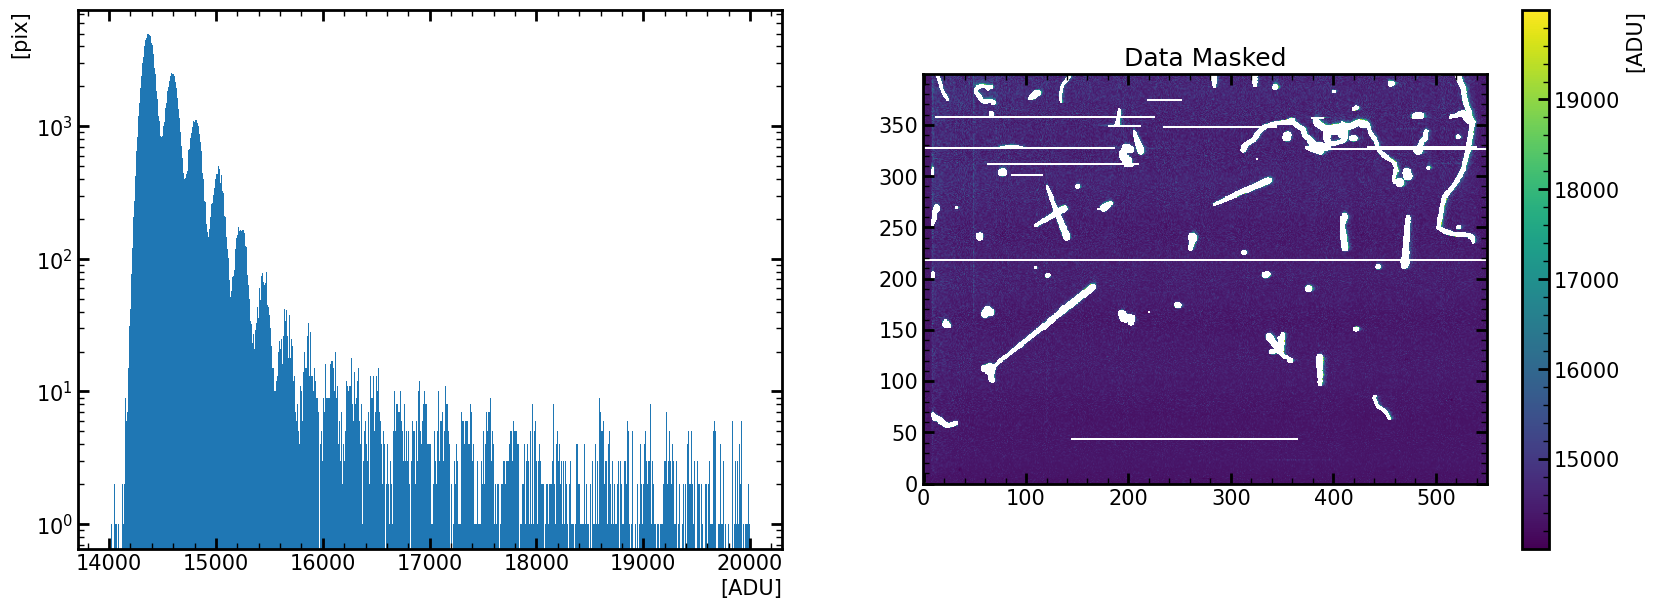

In [53]:

background_data_2=np.ma.masked_array(hdu_list[0].data[:,:550], mask=final_mask)

fig=plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
histograma_AA=plt.hist(background_data_2.flatten(), bins=1000, log=True, )
plt.xlabel('[ADU]')
plt.ylabel('[pix]')

plt.subplot(1,2,2)
plt.title('Data Masked')
plt.imshow(background_data_2)
cbar=plt.colorbar()
cbar.set_label('[ADU]')



## Restar Offset

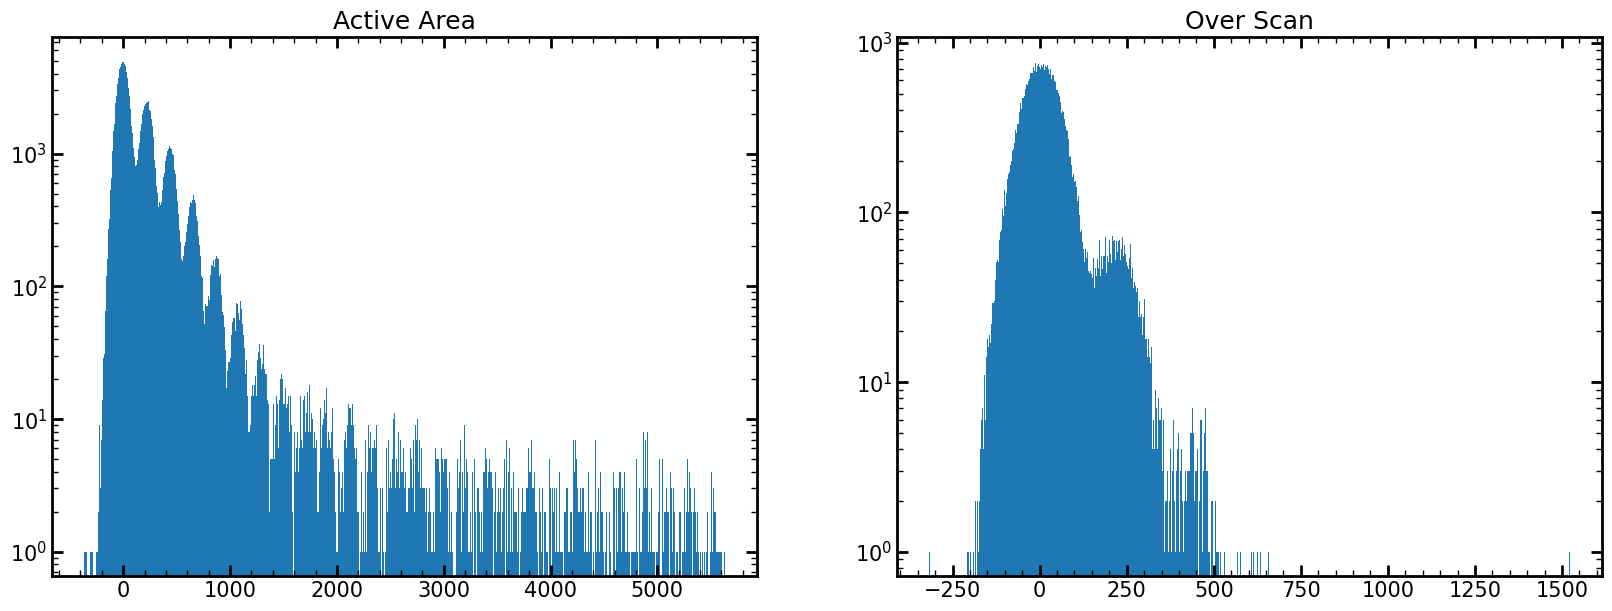

In [54]:
background_data=background_data_2-offset
la_mascara=la_mascara-offset

plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('Active Area')
hist_AA,bins_AA,patches_AA=plt.hist(background_data.flatten(), bins=1000, range=(background_data.min(),background_data.max()), log=True)


plt.subplot(1,2,2)
plt.title('Over Scan')
hist_OS, bins_OS, patches_OS=plt.hist(la_mascara[:,550:].flatten(), bins=1000, range=(la_mascara[:,550:].min(),la_mascara[:,550:].max()), log=True)





In [55]:
bins_OS[np.argmax(hist_OS)]


1.953125e-05

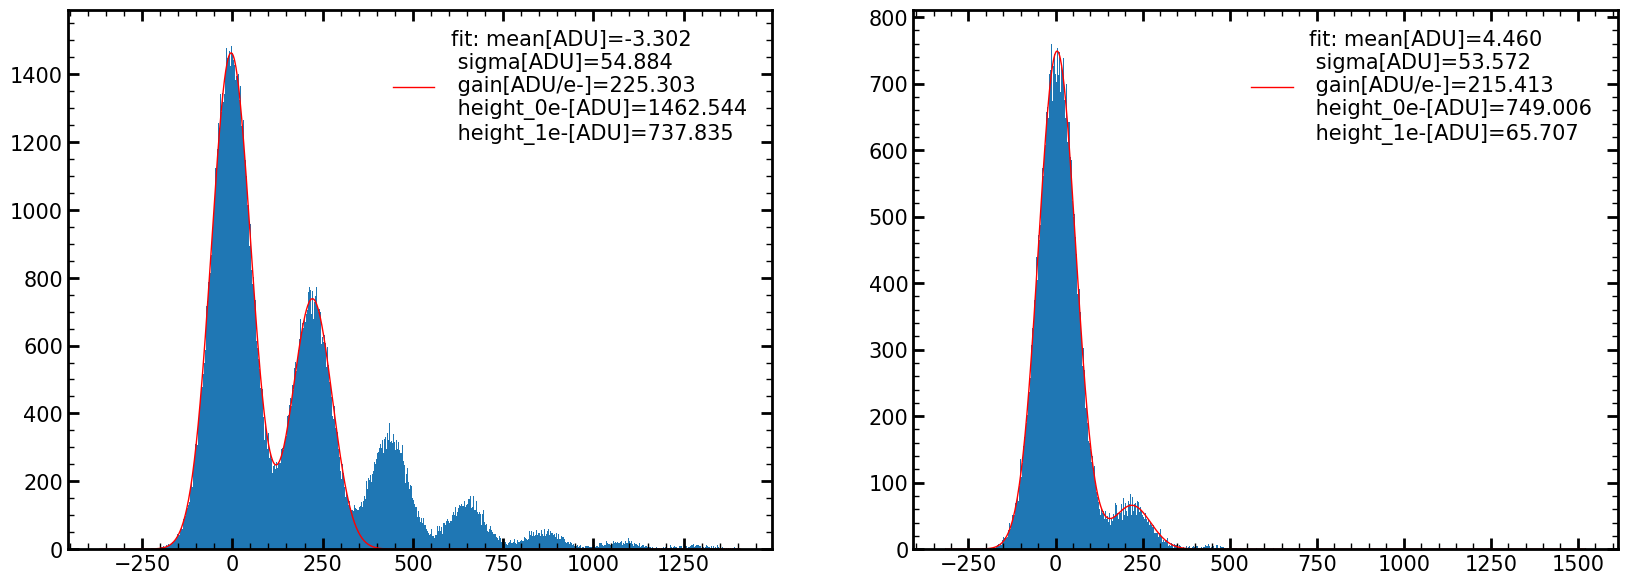

In [64]:
#gaussian2(x,m,s,g,a1,a2): #data, popt (mean, sigma, gain, height1, heigth2)

plt.figure(figsize=(20,7))

# Plot Distribucion y ajuste de la region OS

plt.subplot(1,2,2)
hist_OS, bins_OS, patches_OS=plt.hist(la_mascara[:,550:].flatten(), bins=1000, range=(la_mascara[:,550:].min(),la_mascara[:,550:].max()))


bins=(bins_OS[1:]+bins_OS[:-1])/2
popt_OS,_=curve_fit(gaussian2,bins, hist_OS,p0=[0,80,200,700,50])

plt.plot(bins, gaussian2(bins, *popt_OS), color='red', label='fit: mean[ADU]=%5.3f \n sigma[ADU]=%5.3f \n gain[ADU/e-]=%5.3f \n height_0e-[ADU]=%5.3f \n height_1e-[ADU]=%5.3f' % tuple(popt_OS))
plt.legend()

# Plot Distribucion y ajuste de la region AA

plt.subplot(1,2,1)
hist_AA,bins_AA,patches_AA=plt.hist(background_data.flatten(), bins=1000, range=(background_data.min(),background_data.max()*0.25))#, log=True)

bins=(bins_AA[1:]+bins_AA[:-1])/2
popt_AA,_=curve_fit(gaussian2,bins, hist_AA, p0=[0,80,200,8e3,4e2])

plt.plot(bins, gaussian2(bins, *popt_AA), color='red', label='fit: mean[ADU]=%5.3f \n sigma[ADU]=%5.3f \n gain[ADU/e-]=%5.3f \n height_0e-[ADU]=%5.3f \n height_1e-[ADU]=%5.3f' % tuple(popt_AA))
plt.legend()




## To Do
* Hacer un algoritmo que nos permita identificar la std dev mas idonea para las imagenes con multiples muestras
* Verificar como se comporta este procedimiento en presencia de cross talk
* Utlilizar este algoritmo para cuantificar el exceso de carga que existe entre el OS y el Reverse_OS


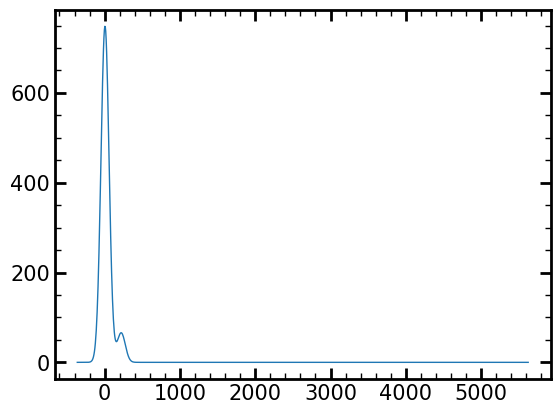

In [57]:
#Guardar objeto en archivo

exampleObj=plt.plot(bins,gaussian2(bins, *popt_OS))

# ICN
fileObj = open('/home/oem/Software/cursoInstrumentacion_2022/ClasesPy/data.obj', 'wb')
# LapTop
#fileObj = open('/home/mauricio/Software/ClasesPy/data.obj', 'wb')

pickle.dump(exampleObj,fileObj)

fileObj.close()




# Chisquare

![chisquare](chisquare.jpeg)

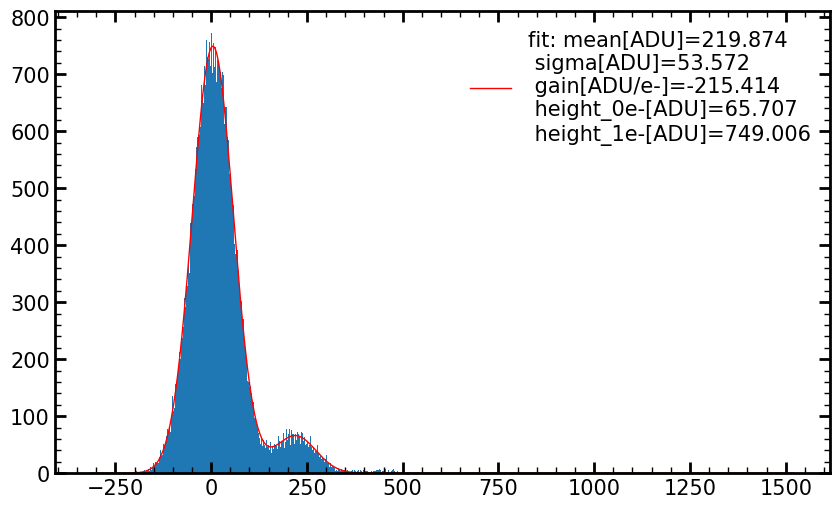

In [58]:
fig = plt.figure(figsize=(10,6))
hist_OS, bins_OS, patches_OS=plt.hist(la_mascara[:,550:].flatten(), bins=1000, range=(la_mascara[:,550:].min(),la_mascara[:,550:].max()))#, log=True)


bins_Os=(bins_OS[1:]+bins_OS[:-1])/2
bins_Os

popt_OS,_=curve_fit(gaussian2,bins_Os, hist_OS)



plt.subplot(1,1,1)
Ajuste=plt.plot(bins_Os, gaussian2(bins_Os, *popt_OS), color='red', label='fit: mean[ADU]=%5.3f \n sigma[ADU]=%5.3f \n gain[ADU/e-]=%5.3f \n height_0e-[ADU]=%5.3f \n height_1e-[ADU]=%5.3f' % tuple(popt_OS))
plt.legend()



In [59]:
MaskList=[]
for bin in hist_OS:
    if bin == 0:
        MaskList.append(1)
    elif bin > 0:
        MaskList.append(0)

maskArray=np.array(MaskList)

MaskedHisto=np.ma.array(hist_OS, mask=maskArray)

el Valor de chisquare es:  510.61913267620014
El ajuste es del modelo es del 0.5126698119238957


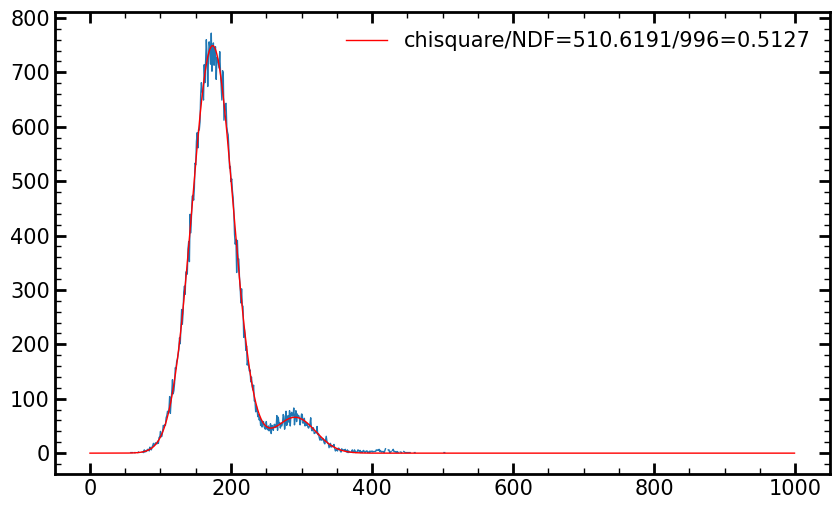

In [60]:
plt.figure(figsize=(10,6))
# # Compute chi square
f = gaussian2(bins_Os, *popt_OS) # popt son los valores optimos del modelo
plt.plot(MaskedHisto)

## r = Di-Fi; Di = hist_Os, Fi = f = gaussian2(bins, *popt_OS)
r=MaskedHisto - f

#sigma=np.sqrt(hist_OS)

## chisquare= np.sum(((Di - Fi)**2/sigma**2)) = np.sum((r**2)/Di)

chisquare=np.sum((r**2)/MaskedHisto)
print('el Valor de chisquare es:  '+str(chisquare))

NDF= len(bins_OS)-len(popt_OS)
print("El ajuste es del modelo es del " + str(chisquare/NDF) )

plt.plot(f, color='r', label=("chisquare/NDF="+str(chisquare.__round__(4))+"/"+str(NDF)+"="+str((chisquare/NDF).__round__(4))) )             # hist_OS son los datos experimentales

plt.legend()

# Single Electron Rate

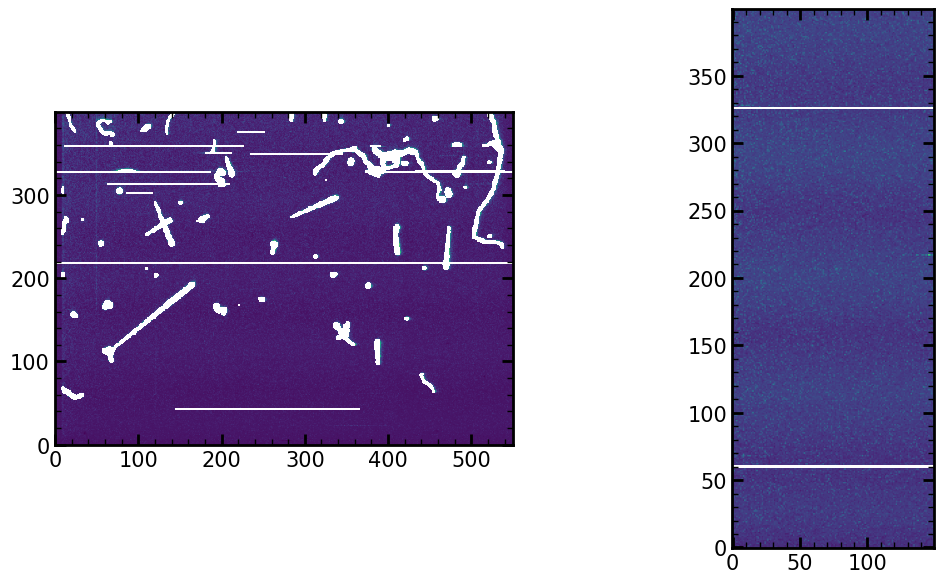

In [61]:
data_masked=[]
OScan_masked=[]
for i in range(0,4,1):
    data_masked.append(np.ma.masked_array(hdu_list[0].data[:,:550], mask=final_mask))
    OScan_masked.append(np.ma.masked_array(hdu_list[0].data[:,550:], mask=serialRegisterEvents_n5[:,550:]))


fig=plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
plt.imshow(data_masked[0])

plt.subplot(1,2,2)
plt.imshow(OScan_masked[0])


OptimizeWarning: Covariance of the parameters could not be estimated

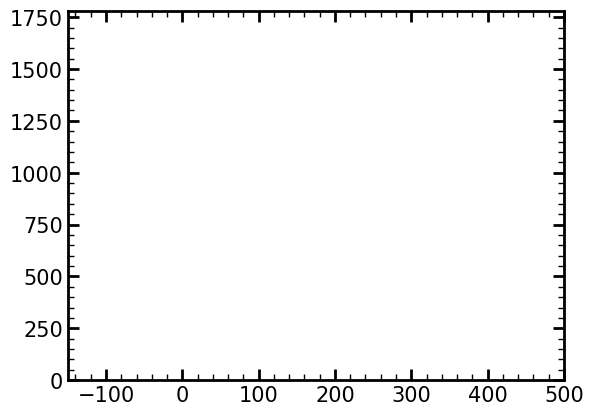

In [62]:
hist, bins,_=plt.hist(data_masked[0].flatten(), bins=3000)
#plt.close()
x = (bins[1:] + bins[:-1])/2
plt.xlim(-150,500)
popt, pcov = curve_fit( gauss, x, hist,p0=[ 0,200,1000])
popt


In [ ]:
def poisson_normN(x, mu, A, lamb, Nmax=5): #sigma parameter global 
    y = 0.
    for i in range(0, Nmax+1):
        y += (lamb**i)/float(math.factorial(i)) *np.exp(-0.5*((x-i-mu-lamb)/float(popt[1]))**2)
    return A*np.exp(-lamb)*y/(np.sqrt(2*np.pi*212))#popt[1]**2))

In [ ]:
try:
    popt, pcov = curve_fit( 
        poisson_normN, 
        x, 
        hist, 
        p0=[-0.4, 250, 0.05],
    )
except (RuntimeError,OptimizeWarning,RuntimeWarning):
    print( f"Error - dc fit failed at" )

Error - dc fit failed at


In [ ]:
plt.plot(poisson_normN(hist, *popt))

NameError: name 'poisson_normN' is not defined

In [ ]:
popt

NameError: name 'popt' is not defined